In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import time
import torch
import torchvision
import torchvision.transforms as T

from collections import Counter
from google.colab import drive
from os import listdir
from os.path import isfile, join
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

### Data Preprocess

In [5]:
# mounts google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# define folder paths
BASE_DIR = '/content/drive/MyDrive/ColabNotebooks/DLProject/data/'
LABEL_PATH = os.path.join(BASE_DIR,'label')
IMAGE_PATH = os.path.join(BASE_DIR,'image')

In [ ]:
# gets list of files with labels/annotations
files_label = [(f) for f in listdir(LABEL_PATH) if isfile(join(LABEL_PATH, f))]
files_label.sort()

In [ ]:
# reads label file and convert it to data frame
def read_labels(label_filename):
    data =  pd.read_csv(os.path.join(LABEL_PATH,label_filename), sep=" ", 
                       names=['label', 'truncated', 'occluded', 'alpha', 
                              'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 
                              'bbox_ymax', 'dim_height', 'dim_width', 'dim_length', 
                              'loc_x', 'loc_y', 'loc_z', 'rotation_y', 'score'])
    
    return data

In [ ]:
# Creates data in faster R-CNN format (FileName, x1, y1, x2, y2, Class)
classes = ['Car', 'Van', 'Truck', 'Pedestrian', 'Cyclist', 'Tram']
label_list = []

for file in files_label:
    df = read_labels(file)
    
    file_name = os.path.splitext(file)[0]
    for index, row in df.iterrows():
        if (row["label"]).strip() in classes:
            record_tup = (file_name + '.png', row["bbox_xmin"], row["bbox_ymin"], row["bbox_xmax"], row["bbox_ymax"], row["label"])
            label_list.append(record_tup)

In [ ]:
# Creates dataframe using label list
df = pd.DataFrame(label_list, columns=['FileName', 'x1', 'y1', 'x2', 'y2', 'Class'])
df

,FileName,x1,y1,x2,y2,Class
0,000000.png,712.40,143.00,810.73,307.92,Pedestrian
1,000001.png,599.41,156.40,629.75,189.25,Truck
2,000001.png,387.63,181.54,423.81,203.12,Car
3,000001.png,676.60,163.95,688.98,193.93,Cyclist
4,000002.png,657.39,190.13,700.07,223.39,Car
...,...,...,...,...,...,...
39370,007480.png,344.07,180.05,479.10,224.15,Car
39371,007480.png,382.70,179.71,495.48,219.10,Car
39372,007480.png,631.71,179.85,678.40,214.37,Car
39373,007480.png,619.92,176.90,647.01,199.92,Car


In [ ]:
# Stores files to drive
df.to_csv(BASE_DIR + 'data.csv')

### Exploring Data

In [7]:
df = pd.read_csv(BASE_DIR + 'data.csv')

In [8]:
unq_values = df["FileName"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unq_values))

Total Records:  39375
Unique Images:  7481


In [9]:
classes = df["Class"].unique()
print("Total Classes: ",len(classes))
print("Classes: ",classes)

Total Classes:  6
Classes:  ['Pedestrian' 'Truck' 'Car' 'Cyclist' 'Van' 'Tram']


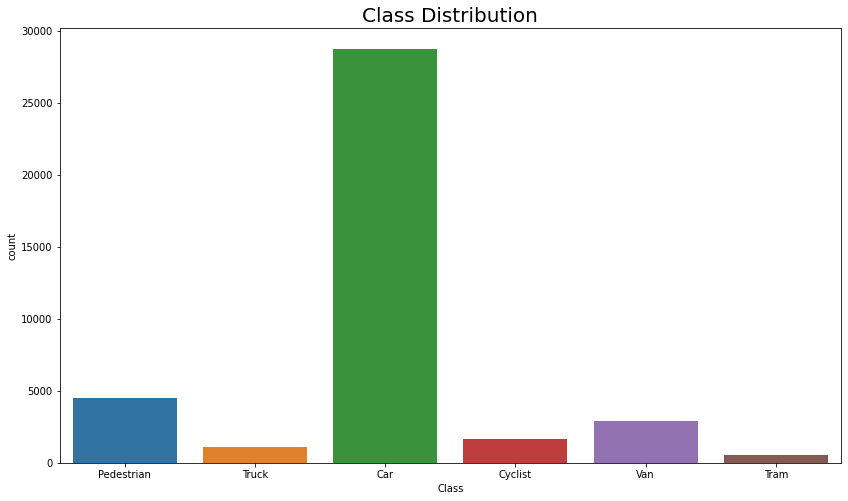

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Class Distribution', fontsize= 20)
sns.countplot(x = "Class", data = df)

In [ ]:
### plot image using ground truth
def plot_img(image_name):
    
    fig, ax = plt.subplots(1, 2, figsize = (20, 20))
    ax = ax.flatten()
    
    bbox = df[df['FileName'] == image_name]
    img_path = os.path.join(IMAGE_PATH, image_name)
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    ax[0].set_axis_off()
    
    for idx, row in bbox.iterrows():
        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        label = row['Class']
        
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, (0,255,0), 2)
    
    ax[1].set_title('Image with true bondary box')
    ax[1].imshow(image2)
    ax[1].set_axis_off()
    plt.show()

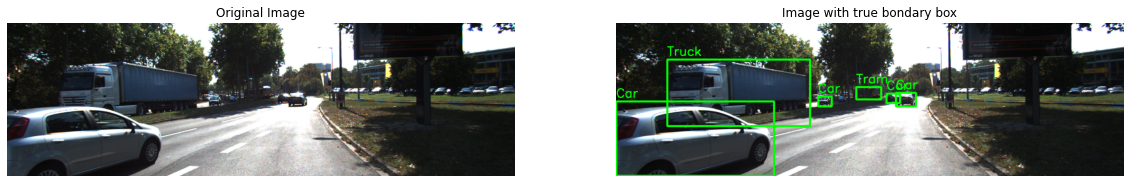

In [ ]:
plot_img('000016.png')

### Preparing dataset for model training

In [10]:
# adding a background class for Faster R-CNN
classes = ['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Van', 'Tram']
_classes = np.insert(classes, 0, "background", axis=0)        
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}

In [ ]:
### Creating Data (Labels & Targets) for Faster R-CNN
class VehicleDataset(Dataset):
    def __init__(self, dataframe, image_dir, mode = 'train', transforms = None):        
        super().__init__()        
        self.image_names = dataframe["FileName"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        
    def __getitem__(self, index: int):        
        #Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df["FileName"] == image_name]
        
        #Loading Image
        image = cv2.imread(self.image_dir + '/' + image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.mode == 'train':            
            #Get bounding box co-ordinates for each box
            boxes = records[['x1', 'y1', 'x2', 'y2']].values

            #Getting labels for each box
            temp_labels = records[['Class']].values
            labels = []
            for label in temp_labels:
                label = class_to_int[label[0]]
                labels.append(label)

            #Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            #Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels

            #Transforms
            if self.transforms:
                image = self.transforms(image)

            return image, target, image_name
        
        elif self.mode == 'test':
            if self.transforms:
                image = self.transforms(image)

            return image, image_name
    
    def __len__(self):
        return len(self.image_names)

In [ ]:
def get_transform():
    return T.Compose([T.ToTensor()])

In [ ]:
#Dataset object
dataset = VehicleDataset(df, IMAGE_PATH, transforms = get_transform())
len(dataset)

7481

In [ ]:
### Preparing data for Train & Validation
def collate_fn(batch):
    return tuple(zip(*batch))

#Dataset object
dataset = VehicleDataset(df, IMAGE_PATH, transforms = get_transform())

# # split the dataset in train and test set - using 70% for training, 20% for validation, and 10% for test
# # Stored it in drive to use for later training
# indices = torch.randperm(len(dataset)).tolist()
# with open(BASE_DIR + 'indeices.pickle', 'wb') as f:
#     pickle.dump(indices, f)

with open(BASE_DIR + 'indeices.pickle', 'rb') as f:
    indices = pickle.load(f)
train_dataset = torch.utils.data.Subset(dataset, indices[:int(.7 * len(dataset))])
valid_dataset = torch.utils.data.Subset(dataset, indices[int(.7 * len(dataset)):int(.9 * len(dataset))])
test_dataset = torch.utils.data.Subset(dataset, indices[int(.9 * len(dataset)):])

#Preparing data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 8,
    shuffle = True,
    collate_fn = collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 8,
    shuffle = True,
    collate_fn = collate_fn
)

### Create Model - Resnet50 FPN (Faster R-CNN) and train

In [11]:
### Utilize GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
print(device)

cuda


In [12]:
### Create / load model

# Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### Preparing model for training
# Retriving all trainable parameters from model for optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr = 0.001, momentum = 0.9)
model.to(device)
epochs = 30 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
def train(epoch, model, optimizer, train_data_loader, train_losses):
  model.train()

  start_time = time.time()
  train_loss = []
  itr = 1
  print(f'Starting epoch: {epoch + 1}')
  print('=' * 30)
    
  #Retriving Mini-batch
  for images, targets, image_names in train_data_loader:
    #Loading images & targets on device
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    #Reseting Gradients
    optimizer.zero_grad()

    #Forward propagation
    out = model(images, targets)
    losses = sum(loss for loss in out.values())

    #Back propagation
    losses.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()
        
    #Average loss
    loss_value = losses.item()
    train_loss.append(loss_value)
        
    if itr % 25 == 0:
      print(f"\n Iteration #{itr} loss: {loss_value} \n")
    itr += 1
    
  epoch_train_loss = np.mean(train_loss)
  train_losses.append(epoch_train_loss)
  print(f'Epoch train loss is {epoch_train_loss:.4f}')

  time_elapsed = time.time() - start_time
  print("Time elapsed: ",time_elapsed)

In [ ]:
def validate(model, valid_data_loader, val_losses):
  model.train()

  start_time = time.time()
  val_loss = []
  itr = 1

  # sets gradient evaluation to false
  with torch.no_grad():  
    #Retriving Mini-batch
    for images, targets, image_names in valid_data_loader:
      #Loading images & targets on device
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      #Forward propagation
      out = model(images, targets)
      losses = sum(loss for loss in out.values())

      #Average loss
      loss_value = losses.item()
      val_loss.append(loss_value)

      if itr % 25 == 0:
        print(f"\n Iteration #{itr} loss: {loss_value} \n")
      itr += 1
    
  epoch_val_loss = np.mean(val_loss)
  val_losses.append(epoch_val_loss)
  print(f'Epoch validation loss is {epoch_val_loss:.4f}')

  time_elapsed = time.time() - start_time
  print("Time elapsed: ",time_elapsed)

In [ ]:
# Load pre-trained model
checkpoint = torch.load(BASE_DIR + "vehicle_frcnn_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
s = checkpoint['epoch']
train_losses = checkpoint['train_loss']
val_losses = checkpoint['val_loss']

In [ ]:
# Trains the model

# not needed when starting training from the middle
# s = 0
# train_losses = []
# val_losses = []
# validate(model, valid_data_loader, val_losses)

for epoch in range(s+1, epochs):
  train(epoch, model, optimizer, train_data_loader, train_losses)
  validate(model, valid_data_loader, val_losses)
  
  chk_name = 'vehicle_frcnn_checkpoint.pth'
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_losses,
            'val_loss': val_losses
            }, BASE_DIR + chk_name)

Starting epoch: 21

 Iteration #25 loss: 0.09767073392868042 


 Iteration #50 loss: 0.3455182909965515 


 Iteration #75 loss: 0.23009717464447021 


 Iteration #100 loss: 0.2976023554801941 


 Iteration #125 loss: 0.1845565140247345 


 Iteration #150 loss: 0.19334666430950165 


 Iteration #175 loss: 0.10596692562103271 


 Iteration #200 loss: 0.26415690779685974 


 Iteration #225 loss: 0.20916040241718292 


 Iteration #250 loss: 0.2663930058479309 


 Iteration #275 loss: 0.27000439167022705 


 Iteration #300 loss: 0.23753522336483002 


 Iteration #325 loss: 0.21966424584388733 


 Iteration #350 loss: 0.23814062774181366 


 Iteration #375 loss: 0.289554625749588 


 Iteration #400 loss: 0.23973295092582703 


 Iteration #425 loss: 0.22771503031253815 


 Iteration #450 loss: 0.261583149433136 


 Iteration #475 loss: 0.30483096837997437 


 Iteration #500 loss: 0.18745172023773193 


 Iteration #525 loss: 0.24935206770896912 


 Iteration #550 loss: 0.1980588734149933 


 I

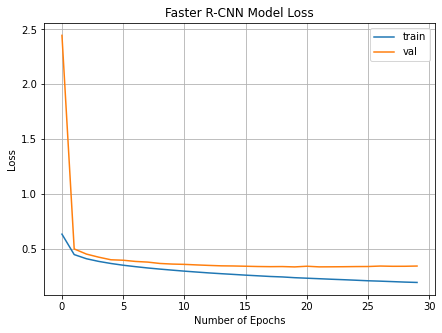

In [ ]:
xc = range(30)
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_losses)
plt.plot(xc,val_losses[:-1])
# plt.scatter(xc, val_losses[:-1])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Faster R-CNN Model Loss')
plt.grid(True)
plt.legend(['train','val'])
plt.show()

In [14]:
# Save the final model after training to be used later 
checkpoint = torch.load(BASE_DIR + "vehicle_frcnn_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

torch.save(model.state_dict(), BASE_DIR + 'frcnn_model.pth')

### Validation by checking output using trained model

In [ ]:
# gets details using the trained model
def get_image_details(model, image_name):
  threshold = 0.2

  img_path = os.path.join(IMAGE_PATH, image_name)
  
  image = cv2.imread(img_path, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
  image /= 255.0
  transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])  
  image = [transform(image).to(device)]

  model.eval()
  #Forward propagation
  output = model(image)
  return output

### plot image
def plot_model_img(model, image_name):
    output = get_image_details(model, image_name)
    threshold = 0.5
    
    fig, ax = plt.subplots(1, 2, figsize = (20, 20))
    ax = ax.flatten()
    
    bbox = df[df['FileName'] == image_name]
    img_path = os.path.join(IMAGE_PATH, image_name)
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
    image2 = image
    
    ax[0].set_title('Input Image')
    ax[0].imshow(image)
    ax[0].set_axis_off()

    for idx, row in bbox.iterrows():
        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        label = row['Class']
    
    #Converting tensors to array
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    labels = output[0]['labels'].data.cpu().numpy()

    #Thresholding
    boxes_th = boxes[scores >= threshold].astype(np.int32)
    scores_th = scores[scores >= threshold]

    # int_to_class - labels
    labels_th = []
    for x in range(len(labels)):
        if scores[x] > threshold:
            labels_th.append(int_to_class[labels[x]])
    
    for y in range(len(boxes_th)):
        x1 = boxes_th[y][0]
        y1 = boxes_th[y][1]
        x2 = boxes_th[y][2]
        y2 = boxes_th[y][3]
        class_name = labels_th[y]
        score = scores_th[y]   
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, class_name, (int(x1),int(y1-10)), font, 1, (255,0,0), 2)

    ax[1].set_title('Image with predicted bondary box using trained model')
    ax[1].imshow(image2)
    ax[1].set_axis_off()
    plt.show()

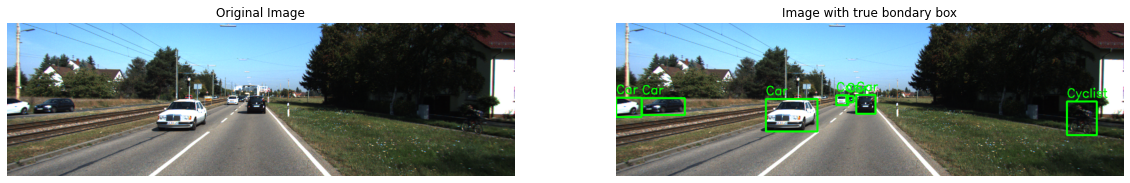

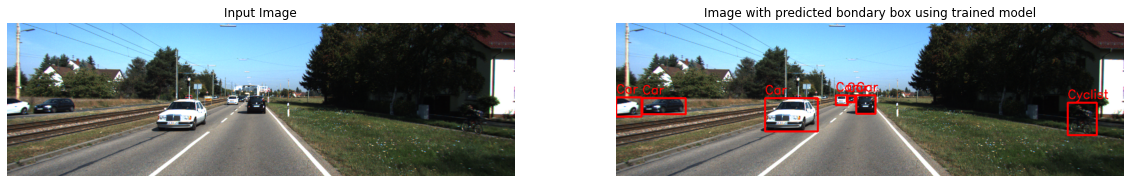

In [ ]:
img_name = '005719.png'
plot_img(img_name)
plot_model_img(model, img_name)

### Evaluation metrics

In [ ]:
### Preparing data for Test

classes = ['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Van', 'Tram'] 
# adding a background class for Faster R-CNN
_classes = np.insert(classes, 0, "background", axis=0)        
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}

def get_transform():
    return T.Compose([T.ToTensor()])

def collate_fn(batch):
    return tuple(zip(*batch))

#Dataset object
dataset = VehicleDataset(df, IMAGE_PATH, transforms = get_transform())

with open(BASE_DIR + 'indeices.pickle', 'rb') as f:
    indices = pickle.load(f)
test_dataset = torch.utils.data.Subset(dataset, indices[int(.9 * len(dataset)):])

#Test data loader
test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
# Calculates intersection over union and returns IoU for all images
def intersection_over_union(boxes_preds, boxes_labels):
    box1_x1 = boxes_preds[..., 0:1]
    box1_y1 = boxes_preds[..., 1:2]
    box1_x2 = boxes_preds[..., 2:3]
    box1_y2 = boxes_preds[..., 3:4]
    box2_x1 = boxes_labels[..., 0:1]
    box2_y1 = boxes_labels[..., 1:2]
    box2_x2 = boxes_labels[..., 2:3]
    box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

# Calculates mAP across all classes given a specific IoU threshold
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, num_classes=7):
    log_message = f'IoU Threshold: {iou_threshold:.2f}, '

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all pred and true, and only add the ones that belong to class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # go through each key, val in this dictionary 
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities 
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # take out the ground_truths that have the same training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:])
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))
        log_message += f'{int_to_class[c]}: {torch.trapz(precisions, recalls):.4f}, '

    print(log_message)
    return sum(average_precisions) / len(average_precisions)

In [ ]:
threshold = 0.5
model.eval()
itr = 1
pred_boxes = []
true_boxes = []

# sets gradient evaluation to false
with torch.no_grad(): 
  image_index = 1 
  #Retriving Mini-batch
  for images, targets, image_names in test_data_loader:
    # print(f'{image_names[0]}')
    # get true boxes details
    boxes = targets[0]['boxes'].data.cpu().numpy()
    labels = targets[0]['labels'].data.cpu().numpy()
    for y in range(len(boxes)):
      #Bboxes, classname & image name
      x1 = boxes[y][0]
      y1 = boxes[y][1]
      x2 = boxes[y][2]
      y2 = boxes[y][3]
      class_num = labels[y]
      score = 1
      true_boxes.append([image_index, class_num, score, x1, y1, x2, y2])

    #Loading images & targets on device
    images = list(image.to(device) for image in images)

    #Forward propagation
    output = model(images)

    #Converting tensors to array
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    labels = output[0]['labels'].data.cpu().numpy()

    #Thresholding
    boxes_th = boxes[scores >= threshold].astype(np.int32)
    scores_th = scores[scores >= threshold]

    # int_to_class - labels
    labels_th = []
    for x in range(len(labels)):
      if scores[x] > threshold:
        labels_th.append(labels[x])
    
    for y in range(len(boxes_th)):
      #Bboxes, classname & image name
      x1 = boxes_th[y][0]
      y1 = boxes_th[y][1]
      x2 = boxes_th[y][2]
      y2 = boxes_th[y][3]
      class_num = labels_th[y]
      score = scores_th[y]
      pred_boxes.append([image_index, class_num, score, x1, y1, x2, y2])

    if image_index % 50 == 0:
      print(f'Processed: {image_index}/{len(test_dataset)}')
    image_index += 1

Processed: 50/749
Processed: 100/749
Processed: 150/749
Processed: 200/749
Processed: 250/749
Processed: 300/749
Processed: 350/749
Processed: 400/749
Processed: 450/749
Processed: 500/749
Processed: 550/749
Processed: 600/749
Processed: 650/749
Processed: 700/749


In [ ]:
map = []
for i in range(10):
  threshold = 0.5 + (0.05 * i)
  map_threshold = mean_average_precision(pred_boxes, true_boxes, threshold)
  print(f'IoU Threshold: {threshold:.2f}, mAP: {map_threshold:.4f}')
  print(f'-'*50)
  map.append(map_threshold)

print(f'\n\nFinal mAP: {(sum(map)/len(map)):.4f}')

IoU Threshold: 0.50, Pedestrian: 0.7989, Truck: 0.9362, Car: 0.9463, Cyclist: 0.8920, Van: 0.9328, Tram: 0.9138, 
IoU Threshold: 0.50, mAP: 0.9033
--------------------------------------------------
IoU Threshold: 0.55, Pedestrian: 0.7672, Truck: 0.9362, Car: 0.9418, Cyclist: 0.8743, Van: 0.9267, Tram: 0.8911, 
IoU Threshold: 0.55, mAP: 0.8895
--------------------------------------------------
IoU Threshold: 0.60, Pedestrian: 0.7402, Truck: 0.9362, Car: 0.9373, Cyclist: 0.8380, Van: 0.9240, Tram: 0.8858, 
IoU Threshold: 0.60, mAP: 0.8769
--------------------------------------------------
IoU Threshold: 0.65, Pedestrian: 0.6510, Truck: 0.9251, Car: 0.9222, Cyclist: 0.8141, Van: 0.9206, Tram: 0.8239, 
IoU Threshold: 0.65, mAP: 0.8428
--------------------------------------------------
IoU Threshold: 0.70, Pedestrian: 0.5602, Truck: 0.9251, Car: 0.8948, Cyclist: 0.7914, Van: 0.8990, Tram: 0.7450, 
IoU Threshold: 0.70, mAP: 0.8026
--------------------------------------------------
IoU Thresh

### SORT integration with Faster R-CNN model

In [ ]:
pip install filterpy

     |████████████████████████████████| 177 kB 9.0 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=073cad5faeeba18aec500fe62ede31ed6e33bcd4a6e1a9c90d52aa0ed09bdf49
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built filterpy


In [ ]:
import os.path
import numpy as np
from skimage import io
from scipy.optimize import linear_sum_assignment as linear_assignment
import time
import argparse
from filterpy.kalman import KalmanFilter

In [ ]:
classes = ['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Van', 'Tram'] 
# adding a background class for Faster R-CNN
_classes = np.insert(classes, 0, "background", axis=0)        
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}

### Utilize GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(class_to_int)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# Load pre-trained model
checkpoint = torch.load(BASE_DIR + "vehicle_frcnn_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Computes IOU between two bboxes in the form [x1,y1,x2,y2]
def iou_batch(bb_test, bb_gt):
  bb_gt = np.expand_dims(bb_gt, 0)
  bb_test = np.expand_dims(bb_test, 1)
  
  xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])
  yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
  xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
  yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
  w = np.maximum(0., xx2 - xx1)
  h = np.maximum(0., yy2 - yy1)
  wh = w * h
  o = wh / ((bb_test[..., 2] - bb_test[..., 0]) * (bb_test[..., 3] - bb_test[..., 1])                                      
    + (bb_gt[..., 2] - bb_gt[..., 0]) * (bb_gt[..., 3] - bb_gt[..., 1]) - wh)                                              
  return(o) 

# From [x1,y1,x2,y2] to [x,y,s,r]
def convert_bbox_to_z(bbox):
  w = bbox[2]-bbox[0]
  h = bbox[3]-bbox[1]
  x = bbox[0]+w/2.
  y = bbox[1]+h/2.
  s = w*h    
  r = w/float(h)
  return np.array([x,y,s,r]).reshape((4,1))

# From [x,y,s,r] to [x1,y1,x2,y2]
def convert_x_to_bbox(x,score=None):
  w = np.sqrt(x[2]*x[3])
  h = x[2]/w
  if(score==None):
    return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
  else:
    return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.,score]).reshape((1,5))

# represents the internel state of individual tracked objects observed as bbox
class KalmanBoxTracker(object):
  count = 0
  def __init__(self,bbox):
    #define constant velocity model
    self.kf = KalmanFilter(dim_x=7, dim_z=4)
    self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
    self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

    self.kf.R[2:,2:] *= 10.
    self.kf.P[4:,4:] *= 1000. 
    self.kf.P *= 10.
    self.kf.Q[-1,-1] *= 0.01
    self.kf.Q[4:,4:] *= 0.01

    self.kf.x[:4] = convert_bbox_to_z(bbox)
    self.time_since_update = 0
    self.id = KalmanBoxTracker.count
    KalmanBoxTracker.count += 1
    self.history = []
    self.hits = 0
    self.hit_streak = 0
    self.age = 0
    # self.objclass = bbox[6]
    # self.objclass = bbox[5]

  # Updates the state vector with observed bbox
  def update(self,bbox):
    self.time_since_update = 0
    self.history = []
    self.hits += 1
    self.hit_streak += 1
    self.kf.update(convert_bbox_to_z(bbox))

  # Advances the state vector and returns the predicted bounding box estimate
  def predict(self):
    if((self.kf.x[6]+self.kf.x[2])<=0):
      self.kf.x[6] *= 0.0
    self.kf.predict()
    self.age += 1
    if(self.time_since_update>0):
      self.hit_streak = 0
    self.time_since_update += 1
    self.history.append(convert_x_to_bbox(self.kf.x))
    return self.history[-1]

  def get_state(self):
    return convert_x_to_bbox(self.kf.x)

# Assigns detections to tracked object
def associate_detections_to_trackers(detections,trackers,iou_threshold = 0.5):
  if(len(trackers)==0):
    return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)

  iou_matrix = iou_batch(detections, trackers)
  
  if min(iou_matrix.shape) > 0:
    a = (iou_matrix > iou_threshold).astype(np.int32)
    if a.sum(1).max() == 1 and a.sum(0).max() == 1:
        matched_indices = np.stack(np.where(a), axis=1)
    else:
      matched_indices = linear_assignment(-iou_matrix)
  else:
    matched_indices = np.empty(shape=(0,2))

  unmatched_detections = []
  for d, det in enumerate(detections):
    # if(d not in matched_indices[:,0]):
    if(d not in [i[0] for i in matched_indices]):
      unmatched_detections.append(d)

  unmatched_trackers = []
  for t, trk in enumerate(trackers):
    # if(t not in matched_indices[:,1]):
    if(t not in [i[1] for i in matched_indices]):
      unmatched_trackers.append(t)

  #filter out matched with low IOU
  matches = []
  for m in matched_indices:
    if(iou_matrix[m[0], m[1]]<iou_threshold):
      unmatched_detections.append(m[0])
      unmatched_trackers.append(m[1])
    else:
      matches.append(m.reshape(1,2))

  if(len(matches)==0):
    matches = np.empty((0,2),dtype=int)
  else:
    matches = np.concatenate(matches,axis=0)

  return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

class Sort(object):
  def __init__(self, max_age=10, min_hits=3, iou_threshold=0.3):
    self.max_age = max_age
    self.min_hits = min_hits
    self.iou_threshold = iou_threshold
    self.trackers = []
    self.frame_count = 0

  # associate bounding box with object id
  def update(self, dets=np.empty((0, 5))):
    self.frame_count += 1
    # get predicted locations from existing trackers.
    trks = np.zeros((len(self.trackers), 5))
    to_del = []
    ret = []
    for t, trk in enumerate(trks):
      pos = self.trackers[t].predict()[0]
      trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
      if np.any(np.isnan(pos)):
        to_del.append(t)
    trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
    for t in reversed(to_del):
      self.trackers.pop(t)
    matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(dets,trks, self.iou_threshold)

    # update matched trackers with assigned detections
    for m in matched:
      self.trackers[m[1]].update(dets[m[0]])
      # self.trackers[m[1]].update(dets[m[0], :])

    # create and initialise new trackers for unmatched detections
    for i in unmatched_dets:
        # trk = KalmanBoxTracker(dets[i,:])
        trk = KalmanBoxTracker(dets[i])
        self.trackers.append(trk)
    i = len(self.trackers)
    for trk in reversed(self.trackers):
        d = trk.get_state()[0]
        if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):
          ret.append(np.concatenate((d,[trk.id+1])).reshape(1,-1)) # +1 as MOT benchmark requires positive
        i -= 1
        # remove dead tracklet
        if(trk.time_since_update > self.max_age):
          self.trackers.pop(i)
    if(len(ret)>0):
      return np.concatenate(ret)
    return np.empty((0,5))   

In [ ]:
def detect_image(image):
    threshold = 0.7
    detections = []
    # convert image to Tensor
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])  
    image = [transform(image).to(device)]
    # run inference on the model and get detections
    model.eval()
    #Forward propagation
    output = model(image)

    #Converting tensors to array
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    labels = output[0]['labels'].data.cpu().numpy()

    #Thresholding
    boxes_th = boxes[scores >= threshold].astype(np.int32)
    scores_th = scores[scores >= threshold]

    # int_to_class - labels
    labels_th = []
    for x in range(len(labels)):
        if scores[x] > threshold:
            labels_th.append(int_to_class[labels[x]])
    

    for y in range(len(boxes_th)):
      #Bboxes, classname & image name
      x1 = boxes_th[y][0]
      y1 = boxes_th[y][1]
      x2 = boxes_th[y][2]
      y2 = boxes_th[y][3]
      class_num = labels_th[y]
      score = scores_th[y]
      detections.append([x1, y1, x2, y2, score])

    return detections

In [ ]:
# videopath = 'video/intersection.mp4'
# %pylab inline 
import cv2
from IPython.display import clear_output

cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 7)]

VIDEO_PATH = '/content/drive/MyDrive/ColabNotebooks/DLProject/data/video/video.mp4'
vid = cv2.VideoCapture(VIDEO_PATH)
mot_tracker = Sort()

# for ii in range(400):
count = 1
while(vid.isOpened()):
    ret, frame = vid.read()
    if count%5 == 0:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).astype(np.float32)
      frame /= 255.0
      
      detections = detect_image(frame)
      if detections is not None:
          tracked_objects = mot_tracker.update(detections)
          
          for x1, y1, x2, y2, obj_id in tracked_objects:
              color = colors[int(obj_id) % len(colors)]
              color = [i * 255 for i in color]
              cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 4)
              
      frame = (frame * 255).astype(np.uint8)
      plt.imshow(frame)
      plt.axis('off')
      plt.show()
      # clear_output(wait=True)
    count += 1

vid.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.